# HOMEWORK 4

In [1]:
import pandas as pd
import numpy as np
import datetime
import warnings

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)
import sys
sys.path.insert(0, '../cmds')
from treasury_cmds import *

1.1)

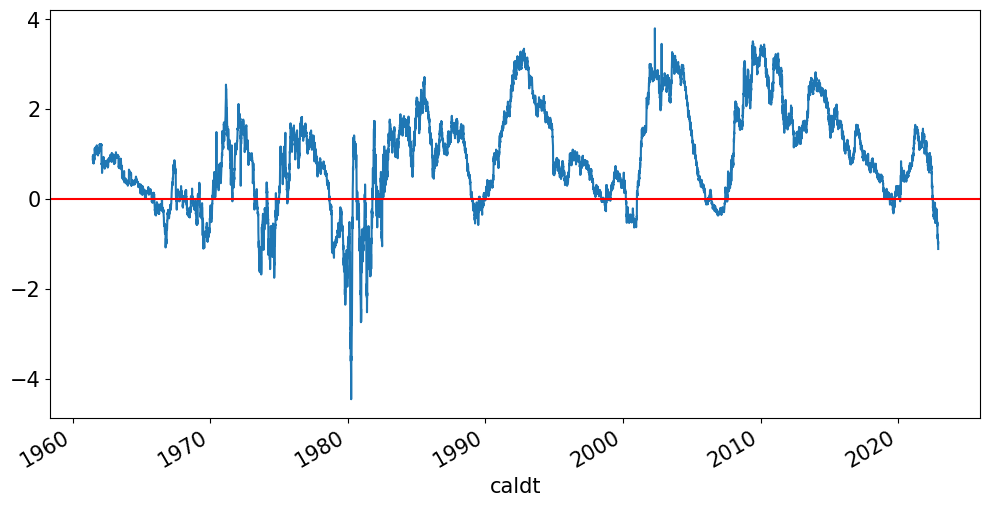

In [2]:
filepath = '/Users/tmac/Library/Containers/com.microsoft.Excel/Data/Downloads/yields_2022-11-30.xlsx'
yields = pd.read_excel(filepath, sheet_name='yields')
yields.set_index('caldt',inplace=True)

TS = yields[10] - yields[1]
ax = TS.plot()
ax.axhline(0, c='r')

The term spread at the end of the series is negative, thus predicting a recession

1.2)

The common explanation for the negative term spread predicting recession is that it reflects the market's forecast of decreasing short-term interest rates due to future economic slowdown.

However, Sacks (and Berner,) are pointing out that the mathematics of yields show there is an extra factor: the term premium, which is a function of the risk premium investors demand for taking on interest-rate risk. Long-term bonds carry interest-rate risk with regard to their short-term valuation. So holding a 10-year bond for 2 years is riskier than holding a 2-year bond for 2 years.

Thus, an inverted yield curve, (i.e. negative term spread,) could be due to a decreasing term premium rather than expected decrease in short rates. A shrinking term premium (risk premium on long term bonds,) is typically associated with a strong market, where risk premia and risk aversion are shrinking.

1.3)

If the term premium is zero...

an upward sloping yield curve is indeed a reflection that the market expects short rates to rise over time.
the market is pricing zero risk premium to long-term bonds. Thus, though there is interest-rate risk to them, the market (in the case of zero term premium,) is saying this is an uncompensated, (and potentially idiosyncratic) risk.
If the term premium jumps up...

This would cause the term spread to jump, without any change to the forecast of future short rates! Similarly, if the premium decreased, the term spread would go down without any change to forecasted short rates.
A positive term premium says the market compensates investors willing to hold long-term bonds, presumably as risk premium for the risk of interest-rate movements (which impact the immediate pricing of the long-term bond) as well as possibly inflation risks.

2.1)

In [3]:
filepath = '/Users/tmac/Library/Containers/com.microsoft.Excel/Data/Downloads/selected_treasury_rates.xlsx'
quotes = pd.read_excel(filepath, sheet_name='data').set_index('KYTREASNO')
quotes

,issue date,maturity date,maturity,coupon rate,price,ytm
KYTREASNO,,,,,,
206896,2015-09-30,2022-09-30,0.501027,1.750,100.363281,0.010144
207688,2021-03-31,2023-03-31,0.999316,0.125,98.457031,0.016804
207775,2021-09-30,2023-09-30,1.500342,0.250,97.218750,0.021307
207077,2017-03-31,2024-03-31,2.001369,2.125,99.570312,0.023294
207416,2019-09-30,2024-09-30,2.502396,1.500,97.621094,0.024680
207507,2020-03-31,2025-03-31,3.000684,0.500,94.175781,0.025101
207256,2018-09-30,2025-09-30,3.501711,3.000,101.554688,0.025142
207337,2019-03-31,2026-03-31,4.000000,2.250,98.929688,0.025154
207777,2021-09-30,2026-09-30,4.501027,0.875,93.042969,0.025020


2.1)

In [5]:
QUOTE_DATE = '2022-03-31'
t_date = pd.to_datetime(QUOTE_DATE)


CF = pd.DataFrame(data=0, index=quotes.index, columns=quotes['maturity date'])

for i in quotes.index:
    coupon_dates = get_coupon_dates(t_date,pd.to_datetime(quotes.loc[i,'maturity date']))

    if coupon_dates is not None:
        CF.loc[i,coupon_dates] = quotes.loc[i,'coupon rate']/2

    CF.loc[i,quotes.loc[i,'maturity date']] += 100

CF = CF.resample('m',axis=1).sum()
CF.drop(columns=CF.columns[(CF==0).all()],inplace=True)
CF = CF.fillna(0).sort_index(axis=1)


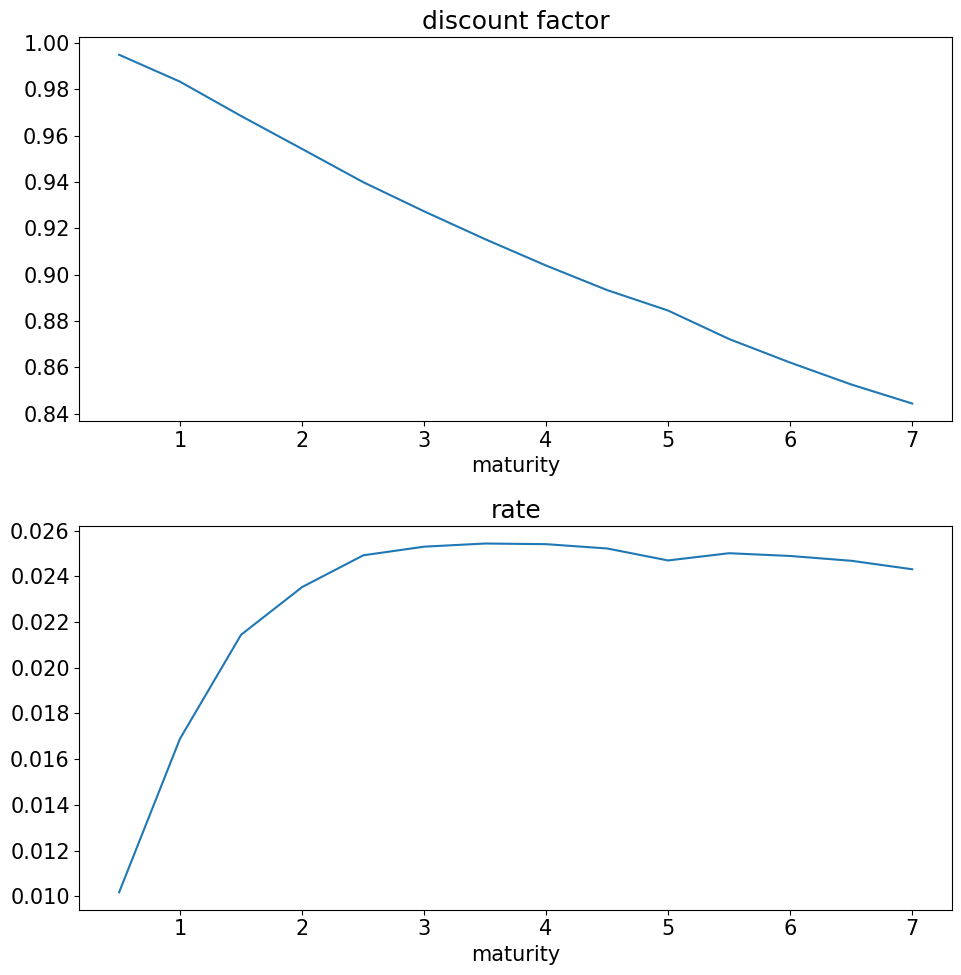

In [6]:
COMPOUNDING = 2
spot = pd.DataFrame(np.linalg.solve(CF,quotes['price'].loc[CF.index]), index=CF.index, columns=['discount factor'])
spot.insert(0,'maturity',quotes['maturity'])
spot = spot.reset_index().set_index('maturity')
spot['rate'] = discount_to_intrate(spot['discount factor'], spot.index,n_compound=COMPOUNDING)

fig, ax = plt.subplots(2,1,figsize=(10,10))
spot['discount factor'].plot(ax=ax[0],title='discount factor')
spot['rate'].plot(ax=ax[1],title='rate')
plt.tight_layout()
plt.show()

2.2)

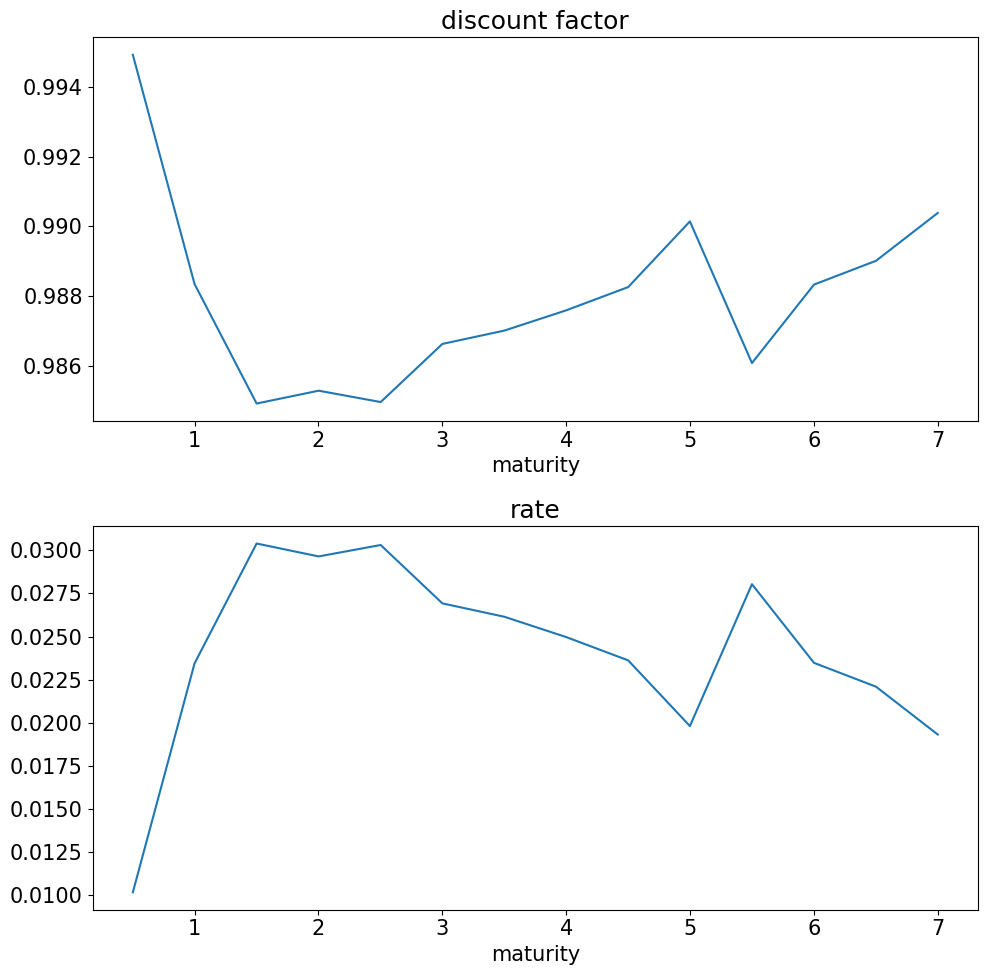

In [7]:
forward = pd.DataFrame(spot['discount factor']/spot['discount factor'].shift(),index=spot.index, columns=['discount factor'])
forward['discount factor'].iloc[0] = spot['discount factor'].iloc[0]
forward['rate'] = -np.log(forward['discount factor']) / forward.index.to_series().diff().mean()

fig, ax = plt.subplots(2,1,figsize=(10,10))
forward['discount factor'].plot(ax=ax[0],title='discount factor')
forward['rate'].plot(ax=ax[1],title='rate')
plt.tight_layout()
plt.show()

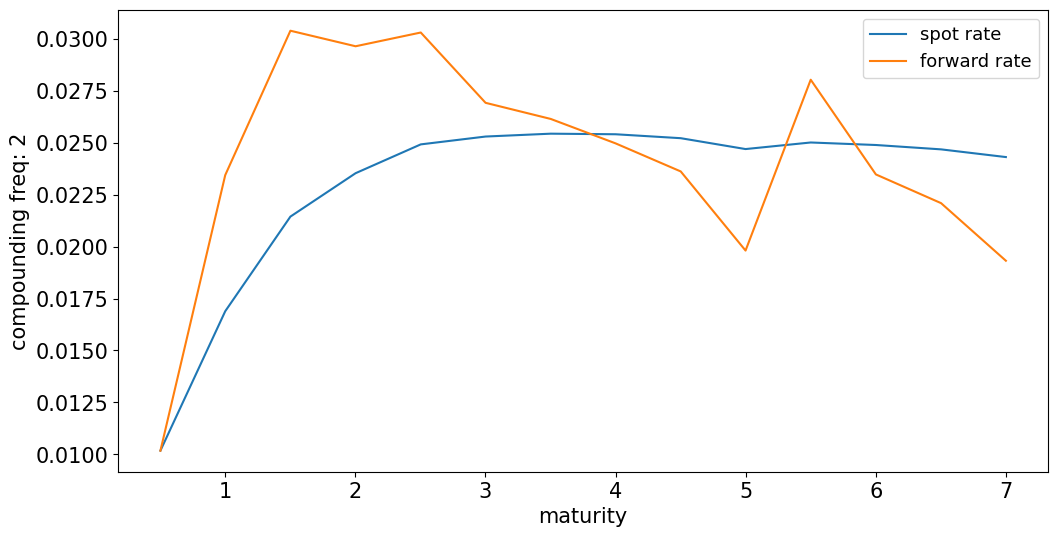

In [8]:
fig, ax = plt.subplots()
spot['rate'].plot(ax=ax)
forward['rate'].plot(ax=ax)
plt.legend(['spot rate','forward rate'])
plt.ylabel(f'compounding freq: {COMPOUNDING}')
plt.show()

2.3)

In [9]:
T2list = [2.5,5.5]
for T2 in T2list:
    forwardrate = forward['rate'].iloc[int(T2*2)]
    print(f'The Forward Rate at {T2-.5} to {T2} is {forwardrate:.2%}')

The Forward Rate at 2.0 to 2.5 is 2.69%
The Forward Rate at 5.0 to 5.5 is 2.35%


The FRA would have contract parameters for...

the notional amount
the dates 
 and 
the floating rate index that will be paid to the counterparty, 
Given that, the counterparties would agree on a forward rate for the exchange of the payment,
where

 is the fraction of year covered by 
.
 is the notional amount.
This fixed forward rate, 
 is what is calculated above.

All the rates above assume 
